In [1]:
import torch
import wandb
import os

import numpy as np

from inference.bayesian.models import TorchModel
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "spain",
            "model_widths": [512, 256, 1],
            "activation": "relu",
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "num_samples": 8000,
            "inference": "dropout",
            "dropout_p": 0.5657121819461798,
            "lr": 0.010684352442920162,
            "num_iterations": 500,
            "plot": True,
            "sweep": False
            }

os.environ["WANDB_MODE"]="offline"
os.environ["WANDB_NOTEBOOK_NAME"]="main_dropout.ipynb"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding, diffXte, diffYte = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 907, Val: 455, Te: 455


# Dropout

In [4]:
torch_model = TorchModel(config.model_widths, config.activation, dropout=True, p=config.dropout_p).to(device)

In [5]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [6]:
predictive, diagnostics = inference(config, torch_model, guide=None,
                                    X_train=train_embedding, Y_train=Ytr,
                                    X_val=val_embedding, Y_val=Yval, 
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

Epoch 1:   0%|          | 0/500 [00:01<?, ?it/s, loss=0.00114]c:\Users\mgphy\Anaconda3\envs\uncertainty\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([455])) that is different to the input size (torch.Size([455, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 24:   5%|▍         | 23/500 [00:01<00:32, 14.57it/s, loss=0.000503]


Early stopping


<Figure size 600x600 with 0 Axes>

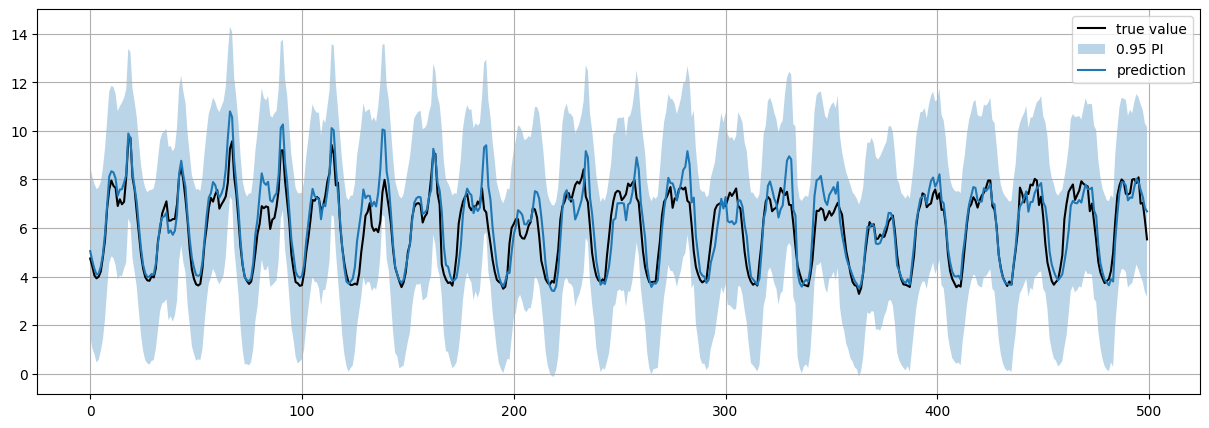

In [7]:
CI = [diagnostics["quantiles"][2], diagnostics["quantiles"][-2]]

plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), CI, "dropout", 500)

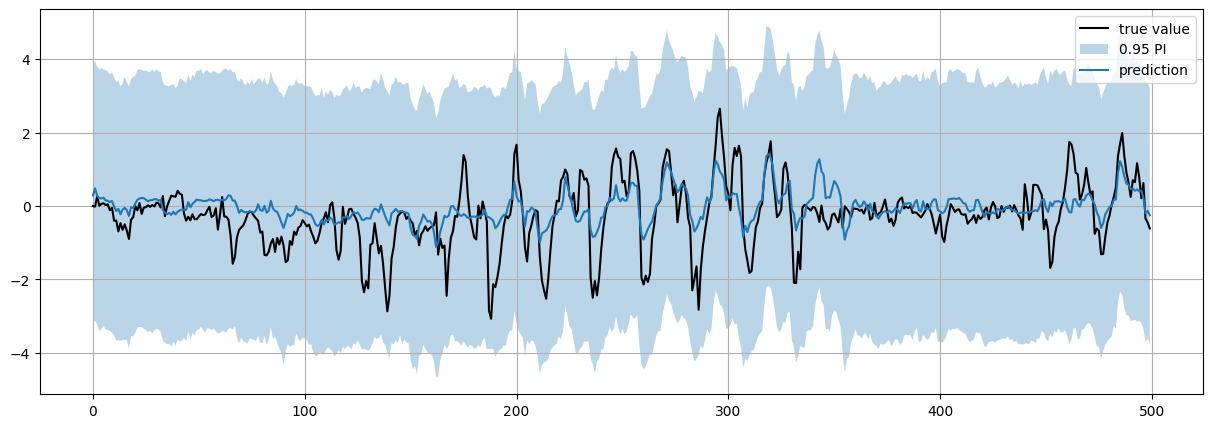

In [8]:
plot_forecast(predictive, torch.concat([torch.zeros(1), Yte[:-1].cpu()]), np.zeros_like(diffXte.squeeze()), np.zeros_like(diffYte.squeeze()), CI, "dropout", 500)

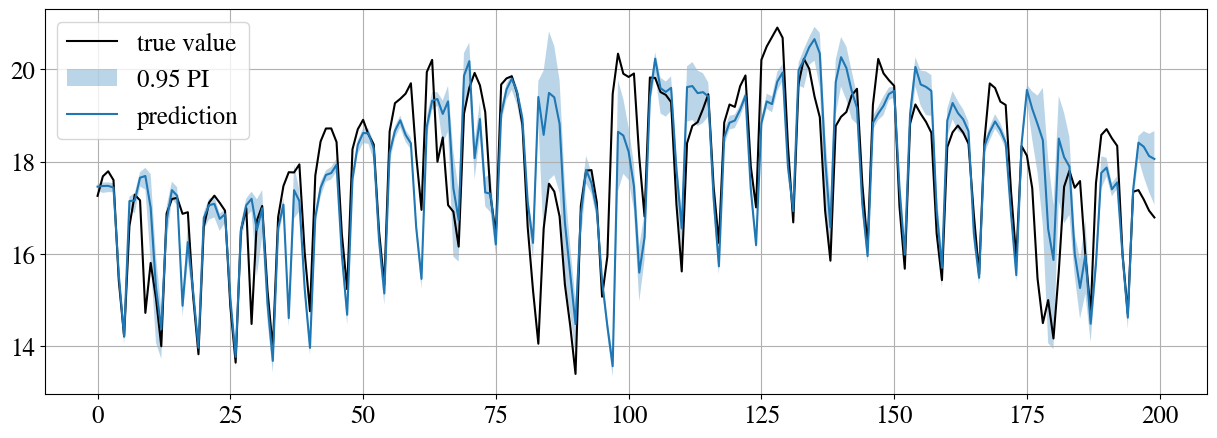

In [7]:
CI = [diagnostics["new_quantiles"][2], diagnostics["new_quantiles"][-2]]

plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), CI, "dropout")

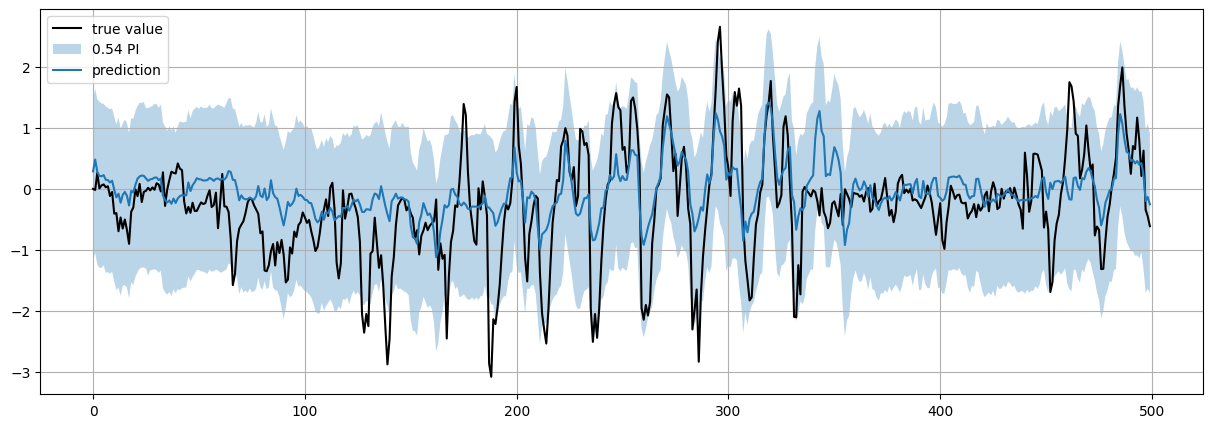

In [10]:
plot_forecast(predictive, torch.concat([torch.zeros(1), Yte[:-1].cpu()]), np.zeros_like(diffXte.squeeze()), np.zeros_like(diffYte.squeeze()), CI, "dropout", 500)

In [11]:
for k, v in diagnostics.items():
    print(k, "\t", v)

train_time 	 0.5625
final_loss 	 0.00018505136540625244
inference_time 	 3.671875
cal_error 	 1.0180426719820892
new_cal_error 	 0.014700470789966941
quantiles 	 [0, 0.005, 0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4, 0.42500000000000004, 0.45, 0.47500000000000003, 0.5, 0.525, 0.55, 0.5750000000000001, 0.6000000000000001, 0.625, 0.65, 0.675, 0.7000000000000001, 0.7250000000000001, 0.75, 0.775, 0.8, 0.8250000000000001, 0.8500000000000001, 0.875, 0.9, 0.925, 0.9500000000000001, 0.9750000000000001, 0.995]
new_quantiles 	 [1.91791331e-04 1.15074799e-03 4.02761795e-03 6.71269659e-03
 8.05523590e-03 1.05485232e-02 1.32336018e-02 1.63022631e-02
 1.87955504e-02 2.10970464e-02 2.62754124e-02 3.18373610e-02
 3.79746835e-02 4.58381281e-02 5.35097814e-02 6.67433832e-02
 8.66896816e-02 1.09512850e-01 1.44994246e-01 1.95051784e-01
 2.75795934e-01 3.85692367e-01 5.08630610e

In [11]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])

training time:  1.265625
calibration error:  2.5800463168699435
Continuous ranked probability score:  0.28682295231827654


In [ ]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')

In [22]:
print(diagnostics)

{'train_time': 0.15625, 'final_loss': 1.3000118129089686, 'inference_time': 3.9375, 'cal_error': 0.5262271349273715, 'new_cal_error': 0.010063895131119206, 'width': 3.382735837280528, 'new_width': 3.799286971885833, 'coverage': 0.9608745684695051, 'avg_length': 0.35469378549754815, 'new_coverage': 0.9689298043728424, 'new_avg_length': 0.3983708876697453, 'mse': 0.5294571854941377, 'new_mse': 0.5666421124706603, 'crps': 0.35827556163579194, 'new_crps': 0.35015292232549283}
